<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Fundamentos de Linguagem Python - Do Básico a Aplicações de IA</font>
# <font color='blue'>Mini-Projeto 5</font>
# <font color='blue'>Modelagem Estatística e Interpretação de Resultados na Análise de Churn</font>

## 1. Importação das Bibliotecas

In [1]:
# Instala o pacote watermark
!pip install -q -U watermark

In [2]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Markdown

In [3]:
# Configurações para melhor visualização
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [5]:
%watermark --iversions

IPython    : 9.7.0
matplotlib : 3.10.6
numpy      : 2.3.2
pandas     : 2.3.1
plotly     : 6.3.0
seaborn    : 0.13.2
statsmodels: 0.14.5



## 2. Definição do Problema de Negócio

In [7]:
display(Markdown("""
## 2.1. Problema de Negócio

A **Connecta Telecom**, uma empresa fictícia de telecomunicações, está enfrentando uma taxa de cancelamento de serviços (churn) acima da média do setor. A perda de clientes não só impacta a receita recorrente, mas também gera custos elevados com a aquisição de novos clientes para substituir os que foram perdidos.

A diretoria precisa de respostas claras e baseadas em dados para a seguinte pergunta: **"Quais são os principais fatores que levam nossos clientes a cancelar o serviço?"**

- Queremos compreender a relação entre variáveis -> Modelagem Estatística
- Se quisermos prever o cancelamento (churn) -> Modelagem Preditiva

## 2.2. Objetivos do Projeto

Este projeto visa utilizar a modelagem estatística para analisar dados de clientes e atingir os seguintes objetivos:

1.  **Identificar os Fatores-Chave:** Determinar quais variáveis (como tipo de contrato, tempo de fidelidade, valor da fatura) têm um impacto estatisticamente significativo na probabilidade de um cliente cancelar o serviço.
2.  **Quantificar o Impacto:** Medir o quão forte é a influência de cada fator no risco de churn.
3.  **Gerar Recomendações:** Traduzir os resultados da análise estatística em recomendações de negócio acionáveis para a criação de estratégias de retenção de clientes.

O modelo escolhido para esta análise será a **Regressão Logística**, pois o nosso objetivo é entender a relação entre diversas variáveis e uma variável de resultado binária (Churn: Sim ou Não).
"""))


## 2.1. Problema de Negócio

A **Connecta Telecom**, uma empresa fictícia de telecomunicações, está enfrentando uma taxa de cancelamento de serviços (churn) acima da média do setor. A perda de clientes não só impacta a receita recorrente, mas também gera custos elevados com a aquisição de novos clientes para substituir os que foram perdidos.

A diretoria precisa de respostas claras e baseadas em dados para a seguinte pergunta: **"Quais são os principais fatores que levam nossos clientes a cancelar o serviço?"**

- Queremos compreender a relação entre variáveis -> Modelagem Estatística
- Se quisermos prever o cancelamento (churn) -> Modelagem Preditiva

## 2.2. Objetivos do Projeto

Este projeto visa utilizar a modelagem estatística para analisar dados de clientes e atingir os seguintes objetivos:

1.  **Identificar os Fatores-Chave:** Determinar quais variáveis (como tipo de contrato, tempo de fidelidade, valor da fatura) têm um impacto estatisticamente significativo na probabilidade de um cliente cancelar o serviço.
2.  **Quantificar o Impacto:** Medir o quão forte é a influência de cada fator no risco de churn.
3.  **Gerar Recomendações:** Traduzir os resultados da análise estatística em recomendações de negócio acionáveis para a criação de estratégias de retenção de clientes.

O modelo escolhido para esta análise será a **Regressão Logística**, pois o nosso objetivo é entender a relação entre diversas variáveis e uma variável de resultado binária (Churn: Sim ou Não).


## 3. Extração dos Dados

In [6]:
# Função para gerar dados fictícios mas coerentes para análise
def dsa_gera_dados_churn(num_clientes = 2000):
    
    """
    Gera um DataFrame de dados fictícios de clientes de uma empresa de telecomunicações.
    """

    # Para reprodutibilidade
    np.random.seed(42)  

    # Variáveis
    fidelidade_meses = np.random.randint(1, 73, size = num_clientes)
    tipo_contrato_opts = ['Mensal', 'Anual', 'Dois anos']
    contrato_probs = [0.6, 0.25, 0.15]
    tipo_contrato = np.random.choice(tipo_contrato_opts, size = num_clientes, p = contrato_probs)
    servico_internet_opts = ['Fibra Óptica', 'DSL', 'Não']
    internet_probs = [0.55, 0.35, 0.10]
    servico_internet = np.random.choice(servico_internet_opts, size = num_clientes, p = internet_probs)

    fatura_base = {
        'Mensal': np.random.normal(60, 20),
        'Anual': np.random.normal(70, 25),
        'Dois anos': np.random.normal(80, 25)
    }
    
    fatura_mensal = [fatura_base[c] + fidelidade_meses[i] * 0.2 + np.random.normal(0, 5) for i, c in enumerate(tipo_contrato)]
    fatura_mensal = np.clip(fatura_mensal, 20, 120)

    # Lógica para a probabilidade de Churn
    # Clientes com contrato mensal, baixa fidelidade e fatura alta têm maior chance de churn
    prob_churn_log = -2.5  # Intercepto base (tendência a não cancelar)
    prob_churn_log += -0.05 * fidelidade_meses  # Mais fidelidade, menor chance
    prob_churn_log += [3.0 if c == 'Mensal' else -1.5 if c == 'Anual' else -2.5 for c in tipo_contrato] # Contrato mensal aumenta muito a chance
    prob_churn_log += [0.8 if s == 'Fibra Óptica' else -0.5 for s in servico_internet] # Fibra tende a ter mais churn (talvez por preço)
    prob_churn_log += 0.03 * fatura_mensal # Fatura mais alta, mais chance
    
    # Converter log-odds para probabilidade usando a função sigmoide
    prob_churn = 1 / (1 + np.exp(-prob_churn_log))
    
    # Gerar o resultado de churn com base na probabilidade
    churn = np.random.binomial(1, prob_churn)

    df = pd.DataFrame({
        'ID_Cliente': range(1, num_clientes + 1),
        'Fidelidade_Meses': fidelidade_meses,
        'Tipo_Contrato': tipo_contrato,
        'Servico_Internet': servico_internet,
        'Fatura_Mensal': fatura_mensal,
        'Churn': churn
    })

    return df

In [8]:
# Gera os dados
df_churn = dsa_gera_dados_churn()

In [9]:
display(Markdown("### Amostra dos Dados Gerados"))
df_churn.head()

### Amostra dos Dados Gerados

,ID_Cliente,Fidelidade_Meses,Tipo_Contrato,Servico_Internet,Fatura_Mensal,Churn
0,1,52,Anual,Fibra Óptica,36.5724,0
1,2,15,Dois anos,Fibra Óptica,45.2871,0
2,3,72,Mensal,Fibra Óptica,101.0033,1
3,4,61,Mensal,Fibra Óptica,103.3314,1
4,5,21,Mensal,DSL,94.0969,1


## 4. Análise Exploratória dos Dados (EDA)

In [10]:
# Informações gerais do DataFrame
display(Markdown("### Informações Gerais do DataFrame"))
df_churn.info()

### Informações Gerais do DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_Cliente        2000 non-null   int64  
 1   Fidelidade_Meses  2000 non-null   int64  
 2   Tipo_Contrato     2000 non-null   object 
 3   Servico_Internet  2000 non-null   object 
 4   Fatura_Mensal     2000 non-null   float64
 5   Churn             2000 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 93.9+ KB


In [11]:
# Resumo estatístico
display(Markdown("### Resumo Estatístico das Variáveis Numéricas"))
display(df_churn.describe())

### Resumo Estatístico das Variáveis Numéricas

,ID_Cliente,Fidelidade_Meses,Fatura_Mensal,Churn
count,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,35.6825,75.3201,0.4905
std,577.4946,20.8430,27.5079,0.5000
min,1.0000,1.0000,24.9216,0.0000
25%,500.7500,17.0000,45.0201,0.0000
50%,1000.5000,35.0000,90.6543,0.0000
75%,1500.2500,54.0000,98.5286,1.0000
max,2000.0000,72.0000,119.2712,1.0000


In [12]:
# Resumo estatístico
display(Markdown("### Resumo Estatístico das Variáveis Categóricas"))
display(df_churn.describe(include='object'))

### Resumo Estatístico das Variáveis Categóricas

,Tipo_Contrato,Servico_Internet
count,2000,2000
unique,3,3
top,Mensal,Fibra Óptica
freq,1186,1114


### 4.1. Gráfico de Taxa de Churn Geral

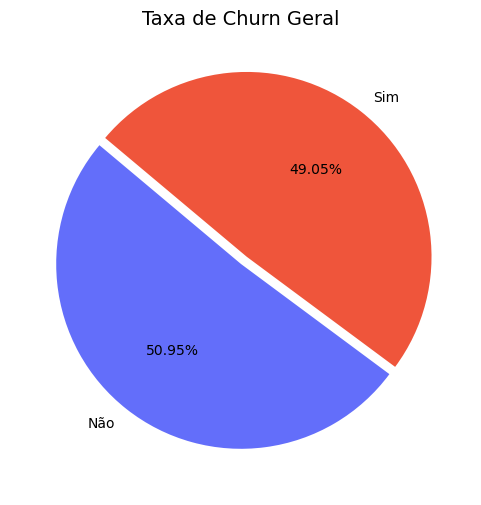

In [13]:
# Gráfico - Versão Estática

# Conta os valores da coluna 'Churn'
churn_counts = df_churn['Churn'].value_counts().rename(index = {1: 'Sim', 0: 'Não'})

# Define as cores equivalentes ao gráfico original
cores = ['#636EFA', '#EF553B']

# Cria o gráfico de pizza com duas casas decimais
plt.figure(figsize = (6,6))
plt.pie(
    churn_counts.values, 
    labels = churn_counts.index, 
    autopct = '%1.2f%%',   # <-- Duas casas decimais
    startangle = 140, 
    colors = cores,
    explode = [0.05 if label == 'Sim' else 0 for label in churn_counts.index]
)
plt.title('Taxa de Churn Geral', fontsize = 14)
plt.show()

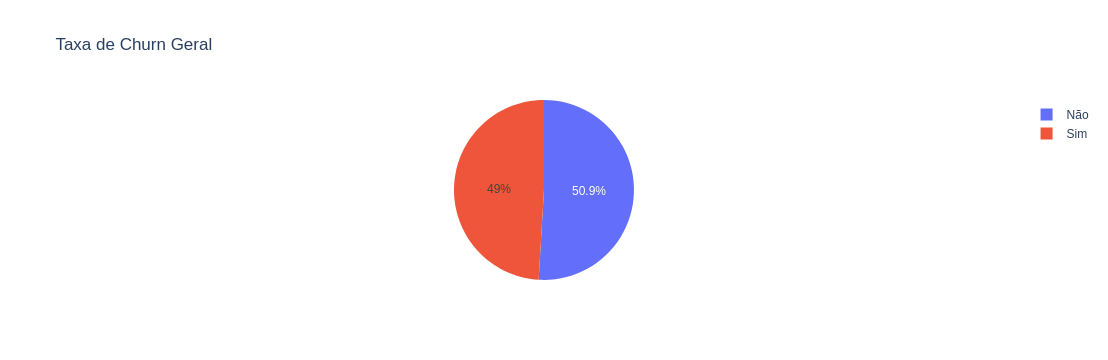

In [14]:
# Gráfico - Versão Interativa

# Calcula a contagem por categoria
churn_counts = df_churn['Churn'].value_counts() 

# Cria o gráfico
fig_pie = px.pie(values = churn_counts.values, 
                 names = churn_counts.index.map({1: 'Sim', 0: 'Não'}), 
                 title = 'Taxa de Churn Geral', 
                 color = churn_counts.index.map({1: 'Sim', 0: 'Não'}), 
                 color_discrete_map = {'Sim':'#EF553B', 'Não':'#636EFA'} ) 
fig_pie.show()

In [15]:
# Calculamos a taxa de churn
churn_counts = df_churn['Churn'].value_counts()
numerador = churn_counts.get(1, churn_counts.get('Sim', churn_counts.get(True, 0)))
taxa = 100 * numerador / len(df_churn)

display(Markdown(f"""
A taxa de churn geral na nossa base de dados é de **{taxa:.2f}%**.
Este é o nosso principal indicador a ser analisado.
"""))


A taxa de churn geral na nossa base de dados é de **49.05%**.
Este é o nosso principal indicador a ser analisado.


### 4.2. Gráfico de Taxa de Churn Por Tipo de Contrato

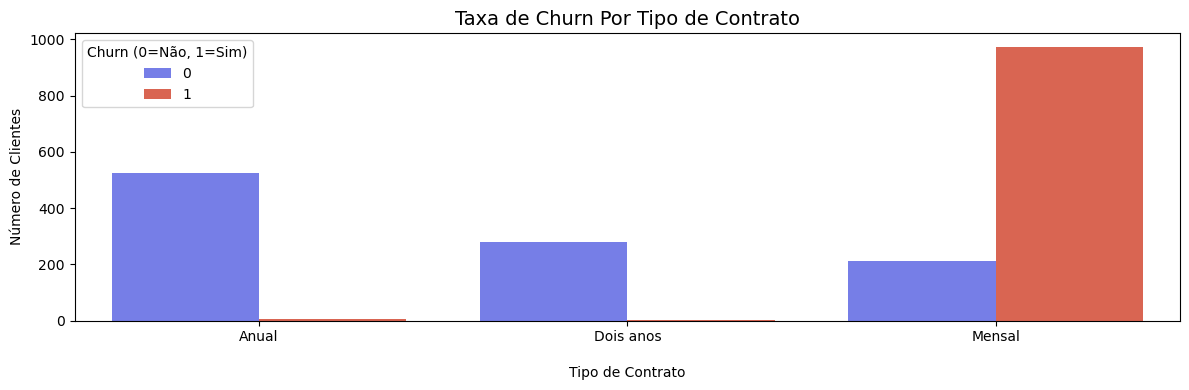

In [16]:
# Gráfico - Versão Estática

plt.figure(figsize = (12,4))

# Cria o gráfico de barras agrupadas com Seaborn
sns.countplot(data = df_churn,
              x = 'Tipo_Contrato',
              hue = 'Churn',
              palette = {0: '#636EFA', 1: '#EF553B'})

plt.title('Taxa de Churn Por Tipo de Contrato', fontsize = 14)
plt.xlabel('\nTipo de Contrato')
plt.ylabel('Número de Clientes')
plt.legend(title = 'Churn (0=Não, 1=Sim)')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

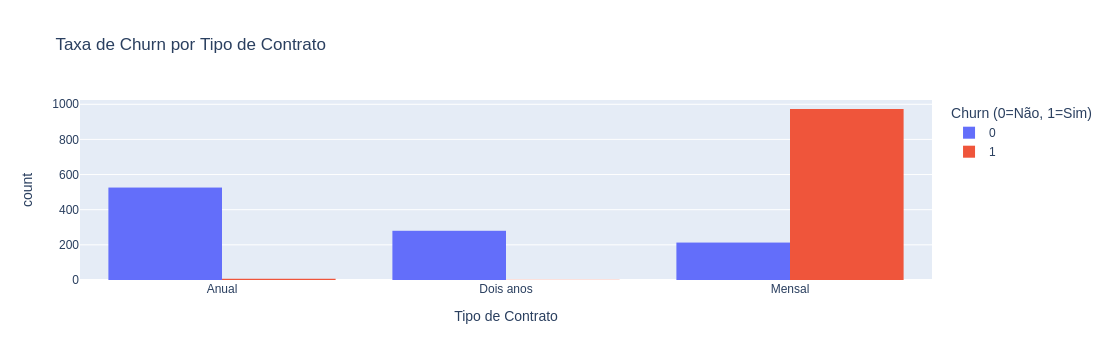

In [17]:
# Gráfico - Versão Interativa

# Histograma
dsa_fig_bar_contrato = px.histogram(df_churn, 
                                    x = 'Tipo_Contrato', 
                                    color = 'Churn', 
                                    barmode = 'group',
                                    title = 'Taxa de Churn por Tipo de Contrato',
                                    labels = {'Tipo_Contrato': 'Tipo de Contrato', 'Churn': 'Churn (0=Não, 1=Sim)'})
dsa_fig_bar_contrato.show()

In [18]:
display(Markdown("""
**Insight:** A visualização é clara: clientes com **contrato mensal** têm uma propensão ao churn drasticamente maior em comparação com clientes de contratos anuais ou de dois anos.
"""))


**Insight:** A visualização é clara: clientes com **contrato mensal** têm uma propensão ao churn drasticamente maior em comparação com clientes de contratos anuais ou de dois anos.


### 4.3. Gráfico de Distribuição da Fidelidade (em Meses) Por Churn

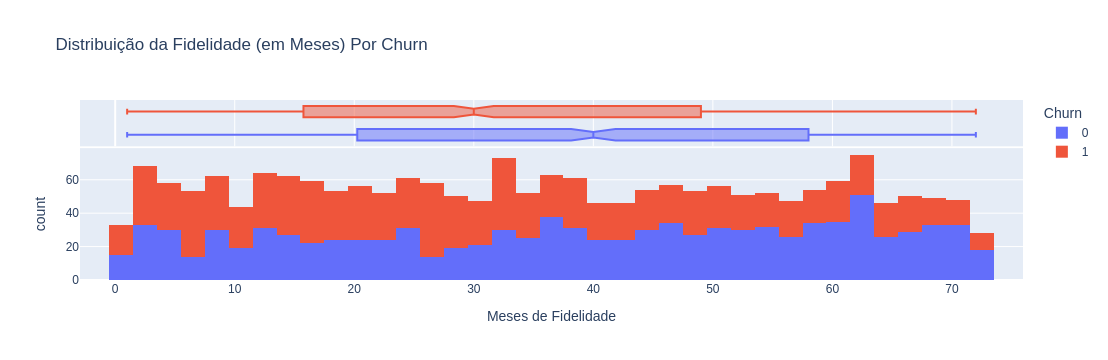

In [19]:
# Gráfico - Versão Interativa

# Análise por Fidelidade (Tenure)
dsa_fig_hist_fidelidade = px.histogram(df_churn, 
                                       x = 'Fidelidade_Meses', 
                                       color = 'Churn', 
                                       marginal = 'box',
                                       title = 'Distribuição da Fidelidade (em Meses) Por Churn',
                                       labels = {'Fidelidade_Meses': 'Meses de Fidelidade'})
dsa_fig_hist_fidelidade.show()

In [20]:
display(Markdown("""
**Insight:** Clientes que cancelam o serviço (`Churn=1`) estão mais concentrados nos primeiros meses de contrato. A mediana de fidelidade para clientes que cancelam é muito menor do que para os que permanecem. Isso indica que o início da jornada do cliente é um período crítico para a retenção.
"""))


**Insight:** Clientes que cancelam o serviço (`Churn=1`) estão mais concentrados nos primeiros meses de contrato. A mediana de fidelidade para clientes que cancelam é muito menor do que para os que permanecem. Isso indica que o início da jornada do cliente é um período crítico para a retenção.


### 4.4. Gráfico de Distribuição da Fatura Mensal Por Churn

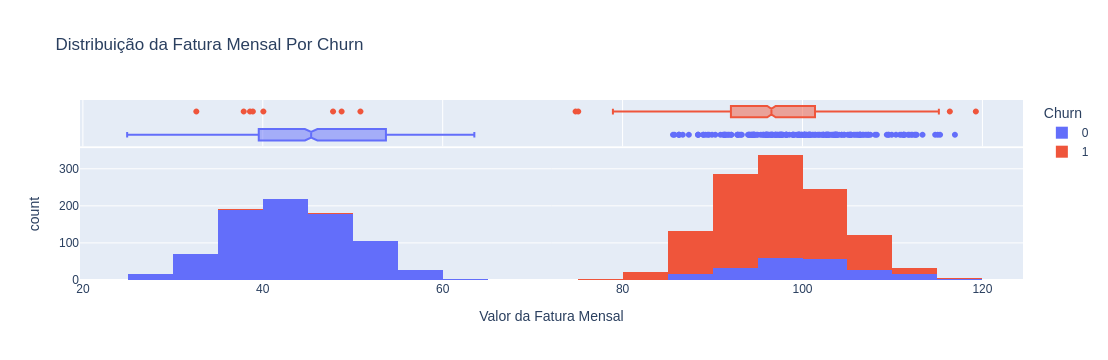

In [21]:
# Gráfico - Versão Interativa

# Análise por Fatura Mensal
dsa_fig_hist_fatura = px.histogram(df_churn, 
                                   x = 'Fatura_Mensal', 
                                   color = 'Churn', 
                                   marginal = 'box',
                                   title = 'Distribuição da Fatura Mensal Por Churn',
                                   labels = {'Fatura_Mensal': 'Valor da Fatura Mensal'})
dsa_fig_hist_fatura.show()

In [22]:
display(Markdown("""
**Insight:** Clientes com faturas mensais mais altas tendem a apresentar uma taxa de churn maior. A mediana do valor da fatura para clientes que cancelaram é notavelmente superior.
"""))


**Insight:** Clientes com faturas mensais mais altas tendem a apresentar uma taxa de churn maior. A mediana do valor da fatura para clientes que cancelaram é notavelmente superior.


## 5. Preparação dos Dados Para a Modelagem Estatística

In [23]:
# Dados originais
df_churn.head()

,ID_Cliente,Fidelidade_Meses,Tipo_Contrato,Servico_Internet,Fatura_Mensal,Churn
0,1,52,Anual,Fibra Óptica,36.5724,0
1,2,15,Dois anos,Fibra Óptica,45.2871,0
2,3,72,Mensal,Fibra Óptica,101.0033,1
3,4,61,Mensal,Fibra Óptica,103.3314,1
4,5,21,Mensal,DSL,94.0969,1


In [24]:
# Categorias da variável
df_churn.Tipo_Contrato.value_counts()

Tipo_Contrato
Mensal       1186
Anual         533
Dois anos     281
Name: count, dtype: int64

In [25]:
# Categorias da variável
df_churn.Servico_Internet.value_counts()

Servico_Internet
Fibra Óptica    1114
DSL              690
Não              196
Name: count, dtype: int64

In [26]:
# Preparação dos dados
# Converter variáveis categóricas em variáveis dummy (0 ou 1)
# Adicionado o parâmetro dtype=int para garantir que as novas colunas sejam numéricas
df_model = pd.get_dummies(df_churn, columns = ['Tipo_Contrato', 'Servico_Internet'], drop_first = True, dtype = int)

Variáveis dummy (ou variáveis indicadoras) são variáveis numéricas criadas para representar categorias em modelos estatísticos ou de Machine Learning. Elas transformam dados qualitativos (como “genero”, “estado civil”, “região”) em valores numéricos, geralmente 0 e 1, permitindo que algoritmos matemáticos consigam processá-los.

Assim, o modelo consegue interpretar diferenças entre grupos sem precisar lidar com texto. As variáveis dummy são uma forma de codificar categorias em números binários, facilitando análises estatísticas e predições. A técnica de criação de variáveis dummy é chamada de One-Hot-Encoding.

In [27]:
# Dados originais
df_churn.head()

,ID_Cliente,Fidelidade_Meses,Tipo_Contrato,Servico_Internet,Fatura_Mensal,Churn
0,1,52,Anual,Fibra Óptica,36.5724,0
1,2,15,Dois anos,Fibra Óptica,45.2871,0
2,3,72,Mensal,Fibra Óptica,101.0033,1
3,4,61,Mensal,Fibra Óptica,103.3314,1
4,5,21,Mensal,DSL,94.0969,1


In [28]:
# Dados processados
df_model.head()

,ID_Cliente,Fidelidade_Meses,Fatura_Mensal,Churn,Tipo_Contrato_Dois anos,Tipo_Contrato_Mensal,Servico_Internet_Fibra Óptica,Servico_Internet_Não
0,1,52,36.5724,0,0,0,1,0
1,2,15,45.2871,0,1,0,1,0
2,3,72,101.0033,1,0,1,1,0
3,4,61,103.3314,1,0,1,1,0
4,5,21,94.0969,1,0,1,0,0


In [29]:
# Resumo dos dados
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID_Cliente                     2000 non-null   int64  
 1   Fidelidade_Meses               2000 non-null   int64  
 2   Fatura_Mensal                  2000 non-null   float64
 3   Churn                          2000 non-null   int64  
 4   Tipo_Contrato_Dois anos        2000 non-null   int64  
 5   Tipo_Contrato_Mensal           2000 non-null   int64  
 6   Servico_Internet_Fibra Óptica  2000 non-null   int64  
 7   Servico_Internet_Não           2000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 125.1 KB


In [30]:
# Definir as variáveis
# Variável dependente (o que queremos prever)
y = df_model['Churn']

In [31]:
# Variáveis independentes (as que usamos para prever)
# Excluímos a ID do cliente e a variável alvo original
X = df_model.drop(['ID_Cliente', 'Churn'], axis = 1)

In [32]:
# Adicionar uma constante (intercepto) ao modelo, exigido pela biblioteca statsmodels
X = sm.add_constant(X)

In [33]:
display(Markdown("### Amostra dos Dados (X) Preparados Para o Modelo"))
display(X.head())

### Amostra dos Dados (X) Preparados Para o Modelo

,const,Fidelidade_Meses,Fatura_Mensal,Tipo_Contrato_Dois anos,Tipo_Contrato_Mensal,Servico_Internet_Fibra Óptica,Servico_Internet_Não
0,1.0000,52,36.5724,0,0,1,0
1,1.0000,15,45.2871,1,0,1,0
2,1.0000,72,101.0033,0,1,1,0
3,1.0000,61,103.3314,0,1,1,0
4,1.0000,21,94.0969,0,1,0,0


In [34]:
display(Markdown("### Amostra dos Dados (y) Preparados Para o Modelo"))
display(y.head())

### Amostra dos Dados (y) Preparados Para o Modelo

0    0
1    0
2    1
3    1
4    1
Name: Churn, dtype: int64

## 6. Modelagem Estatística

In [35]:
display(Markdown("Vamos construir um modelo para quantificar o impacto de cada variável na probabilidade de churn."))

Vamos construir um modelo para quantificar o impacto de cada variável na probabilidade de churn.

In [36]:
# Criamos o modelo
modelo = sm.Logit(y, X)

In [37]:
type(modelo)

statsmodels.discrete.discrete_model.Logit

In [38]:
# Treinamento do modelo
modelo_treinado = modelo.fit()

Optimization terminated successfully.
         Current function value: 0.245933
         Iterations 10


In [39]:
# Exibir o resumo completo do modelo
display(Markdown("### Resultados do Modelo de Regressão Logística"))
modelo_treinado.summary()

### Resultados do Modelo de Regressão Logística

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            6
Date:                Wed, 11 Feb 2026   Pseudo R-squ.:                  0.6451
Time:                        14:25:37   Log-Likelihood:                -491.87
converged:                       True   LL-Null:                       -1385.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -5.2263      0.714     -7.316      0.000      -6.627      -3.826
Fidelidade_Meses                 -0.0556      0.006     -9.883      0.000      -0.067      -0.045
Fatura_Mensal                     0.0316      0.016      2.004      0.045       0.001       0.062
Tipo_Contrato_Dois anos          -1.2741      1.075     -1.185      0.236      -3.382       0.834
Tipo_Contrato_Mensal              5.2739      0.934      5.647      0.000       3.443       7.104
Servico_Internet_Fibra Óptica     1.4550      0.180      8.091      0.000       1.103       1.807
Servico_Internet_Não              0.2096      0.264      0.793      0.428      -0.308       0.727
=================================================================================================
"""

## 7. Interpretação dos Resultados

In [40]:
display(Markdown("""
O resumo acima contém informações ricas sobre o nosso modelo. Vamos focar nos pontos mais importantes para o negócio:

1.  **Coeficientes (`coef`):** Mostram a direção do impacto. Um coeficiente positivo aumenta a chance de churn, enquanto um negativo a diminui.
2.  **Valor-p (`P>|z|`):** Indica a significância estatística de cada variável. Um valor-p baixo (geralmente < 0.05) significa que o efeito da variável é real e não apenas uma coincidência na amostra.
3.  **Pseudo R-squ.:** Similar ao R² na regressão linear, indica a proporção da "variância" da variável dependente que é explicada pelo modelo. Um valor de 0.645 (ou 65%) é considerado um bom ajuste para este tipo de modelo.

Para facilitar a interpretação, vamos calcular a **Razão de Chances (Odds Ratio)**, que nos diz como as chances de churn mudam com o aumento de uma unidade na variável independente.
"""))


O resumo acima contém informações ricas sobre o nosso modelo. Vamos focar nos pontos mais importantes para o negócio:

1.  **Coeficientes (`coef`):** Mostram a direção do impacto. Um coeficiente positivo aumenta a chance de churn, enquanto um negativo a diminui.
2.  **Valor-p (`P>|z|`):** Indica a significância estatística de cada variável. Um valor-p baixo (geralmente < 0.05) significa que o efeito da variável é real e não apenas uma coincidência na amostra.
3.  **Pseudo R-squ.:** Similar ao R² na regressão linear, indica a proporção da "variância" da variável dependente que é explicada pelo modelo. Um valor de 0.645 (ou 65%) é considerado um bom ajuste para este tipo de modelo.

Para facilitar a interpretação, vamos calcular a **Razão de Chances (Odds Ratio)**, que nos diz como as chances de churn mudam com o aumento de uma unidade na variável independente.


A Razão de Chances (ou Odds Ratio) é uma medida usada para comparar a probabilidade de um evento ocorrer entre dois grupos. Ela é muito comum em estatística e modelos como a regressão logística.

De forma simples, a “chance” (odds) de um evento é a razão entre a probabilidade de ele acontecer e a probabilidade de não acontecer. Por exemplo, se a probabilidade de um cliente comprar um produto é 0,8 (80%), então a chance é 0,8 / 0,2 = 4. Isso quer dizer que a chance de compra é 4 vezes maior do que a de não compra.

In [41]:
# Calcular e exibir as razões de chance (Odds Ratios)
params = modelo_treinado.params
conf = modelo_treinado.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
conf = np.exp(conf)
display(Markdown("### Tabela de Razão de Chances (Odds Ratio)"))
display(conf)

### Tabela de Razão de Chances (Odds Ratio)

,2.5%,97.5%,Odds Ratio
const,0.0013,0.0218,0.0054
Fidelidade_Meses,0.9355,0.9564,0.9459
Fatura_Mensal,1.0007,1.0644,1.0321
Tipo_Contrato_Dois anos,0.0340,2.3019,0.2797
Tipo_Contrato_Mensal,31.2962,1217.3069,195.1849
Servico_Internet_Fibra Óptica,3.0118,6.0947,4.2844
Servico_Internet_Não,0.7347,2.0697,1.2331


## Interpretação da Razão de Chances Para o Negócio:

**1. const (intercepto)**

O valor 0.0054 representa a chance base de churn quando todas as outras variáveis são zero. Ele por si só não tem interpretação prática relevante e serve como ponto de partida do modelo.

**2. Fidelidade_Meses (0.9459)**

O odds ratio é menor que 1, o que indica um efeito protetor: quanto mais meses de fidelidade, menor a chance de churn. Cada mês adicional reduz em cerca de (1 - 0.9459) × 100 ≈ 5,4% a chance de o cliente cancelar.

**3. Fatura_Mensal (1.0321)**

Um valor ligeiramente acima de 1 mostra que quanto maior a fatura mensal, maior a chance de churn. A cada aumento unitário (por exemplo, R$ 1), a chance cresce em torno de 3,2%. Isso pode indicar insatisfação com preços mais altos.

**4. Tipo_Contrato_Dois anos (0.2797)**

O valor é menor que 1, o que significa que clientes com contrato de dois anos têm menor probabilidade de cancelar comparados ao grupo de referência (por exemplo “Contrato de um ano”). Isso sugere que contratos longos retêm melhor os clientes.

**5. Tipo_Contrato_Mensal (195.1849)**

Um valor muito alto mostra que clientes com contrato mensal têm probabilidade muito maior de cancelar, cerca de 195 vezes maior do que o grupo de referência. Isso é típico: contratos mensais são mais flexíveis e os clientes saem mais facilmente.

**6. Servico_Internet_Fibra Óptica (4.2844)**

Clientes com fibra óptica têm 4,28 vezes mais chance de churn que os que usam outro tipo de internet (como DSL, que seria o grupo base). Pode indicar que esse grupo é mais exigente ou sensível a falhas de serviço.

**7. Servico_Internet_Não (1.2331)**

Clientes sem serviço de internet têm uma chance 23% maior de churn em relação ao grupo base, mas o intervalo de confiança (0.73 a 2.06) inclui 1, o que sugere baixa significância estatística, ou seja, o efeito pode não ser real.

Em resumo:

- Fidelidade e contrato de longo prazo reduzem churn.
- Fatura alta, contrato mensal e fibra óptica aumentam churn.
- O odds ratio mostra o tamanho e a direção do efeito de cada variável sobre a probabilidade de cancelamento.

## 8. Relatório Final - Conclusões e Recomendações Estratégicas

In [42]:
display(Markdown("""
# Relatório Final: Conclusões e Recomendações Estratégicas

## Conclusões

A análise estatística revelou, com alto grau de confiança, os principais impulsionadores do churn de clientes na **Connecta Telecom**. Os resultados do modelo de regressão logística confirmam que o cancelamento está fortemente associado a alguns fatores comportamentais e contratuais específicos. O perfil de cliente com **alto risco de churn** é: **cliente recente, com contrato mensal, fatura elevada e serviço de Fibra Óptica**.

Os fatores mais significativos, em ordem de impacto, são:
1. **Tipo de Contrato:** Clientes com contrato mensal apresentam um risco de cancelamento aproximadamente **195 vezes maior** em relação aos de contratos mais longos. Contratos de dois anos são o principal fator de proteção.
2. **Tempo de Fidelidade:** Cada mês adicional de permanência reduz a chance de churn em cerca de **5%**, mostrando que os primeiros meses são cruciais para a retenção.
3. **Valor da Fatura Mensal:** O aumento no valor da fatura mensal eleva o risco de churn em aproximadamente **3% por unidade monetária**, sugerindo sensibilidade a preço.
4. **Tipo de Serviço de Internet:** O serviço de **Fibra Óptica** aumenta em cerca de **4 vezes** a chance de cancelamento em comparação com o DSL, possivelmente devido a expectativas não atendidas ou à percepção de custo elevado.

## Recomendações Acionáveis

Com base nessas conclusões, propõem-se as seguintes ações estratégicas para o time de retenção:

| Recomendação | Justificativa (Baseada nos Dados) | Ação Proposta |
| :--- | :--- | :--- |
| **1. Incentivar a Migração para Contratos de Longo Prazo** | O contrato mensal está associado a um risco **extremamente alto de churn (≈195x)**. | Criar uma campanha promocional para converter clientes mensais em anuais ou bienais, oferecendo incentivos como descontos, bônus de fidelidade ou upgrades temporários de velocidade. |
| **2. Criar um Programa de Fidelização para Novos Clientes** | Cada mês adicional reduz a chance de churn em **5%**. | Implementar um programa de acompanhamento intensivo nos seis primeiros meses, com comunicações personalizadas, suporte proativo e benefícios progressivos para reforçar a satisfação inicial. |
| **3. Revisar a Estratégia de Preços e Valor Percebido** | Faturas mais altas aumentam a chance de churn em **3%** por unidade. | Segmentar clientes com faturas elevadas e realizar uma análise de elasticidade de preço. Ajustar pacotes para melhorar o valor percebido (mais benefícios pelo mesmo preço). |
| **4. Investigar o Churn no Segmento de Fibra Óptica** | Clientes com Fibra têm **4x mais chances de cancelar**. | Conduzir uma pesquisa de satisfação e uma análise técnica detalhada sobre a qualidade do serviço e suporte. Identificar causas de insatisfação e agir sobre problemas de performance ou atendimento. |

A adoção dessas recomendações, baseadas em evidências estatísticas sólidas e profissionais, permitirá à **Connecta Telecom** reduzir substancialmente o churn, aumentar a fidelização e fortalecer sua base de receita recorrente.
"""))


# Relatório Final: Conclusões e Recomendações Estratégicas

## Conclusões

A análise estatística revelou, com alto grau de confiança, os principais impulsionadores do churn de clientes na **Connecta Telecom**. Os resultados do modelo de regressão logística confirmam que o cancelamento está fortemente associado a alguns fatores comportamentais e contratuais específicos. O perfil de cliente com **alto risco de churn** é: **cliente recente, com contrato mensal, fatura elevada e serviço de Fibra Óptica**.

Os fatores mais significativos, em ordem de impacto, são:
1. **Tipo de Contrato:** Clientes com contrato mensal apresentam um risco de cancelamento aproximadamente **195 vezes maior** em relação aos de contratos mais longos. Contratos de dois anos são o principal fator de proteção.
2. **Tempo de Fidelidade:** Cada mês adicional de permanência reduz a chance de churn em cerca de **5%**, mostrando que os primeiros meses são cruciais para a retenção.
3. **Valor da Fatura Mensal:** O aumento no valor da fatura mensal eleva o risco de churn em aproximadamente **3% por unidade monetária**, sugerindo sensibilidade a preço.
4. **Tipo de Serviço de Internet:** O serviço de **Fibra Óptica** aumenta em cerca de **4 vezes** a chance de cancelamento em comparação com o DSL, possivelmente devido a expectativas não atendidas ou à percepção de custo elevado.

## Recomendações Acionáveis

Com base nessas conclusões, propõem-se as seguintes ações estratégicas para o time de retenção:

| Recomendação | Justificativa (Baseada nos Dados) | Ação Proposta |
| :--- | :--- | :--- |
| **1. Incentivar a Migração para Contratos de Longo Prazo** | O contrato mensal está associado a um risco **extremamente alto de churn (≈195x)**. | Criar uma campanha promocional para converter clientes mensais em anuais ou bienais, oferecendo incentivos como descontos, bônus de fidelidade ou upgrades temporários de velocidade. |
| **2. Criar um Programa de Fidelização para Novos Clientes** | Cada mês adicional reduz a chance de churn em **5%**. | Implementar um programa de acompanhamento intensivo nos seis primeiros meses, com comunicações personalizadas, suporte proativo e benefícios progressivos para reforçar a satisfação inicial. |
| **3. Revisar a Estratégia de Preços e Valor Percebido** | Faturas mais altas aumentam a chance de churn em **3%** por unidade. | Segmentar clientes com faturas elevadas e realizar uma análise de elasticidade de preço. Ajustar pacotes para melhorar o valor percebido (mais benefícios pelo mesmo preço). |
| **4. Investigar o Churn no Segmento de Fibra Óptica** | Clientes com Fibra têm **4x mais chances de cancelar**. | Conduzir uma pesquisa de satisfação e uma análise técnica detalhada sobre a qualidade do serviço e suporte. Identificar causas de insatisfação e agir sobre problemas de performance ou atendimento. |

A adoção dessas recomendações, baseadas em evidências estatísticas sólidas e profissionais, permitirá à **Connecta Telecom** reduzir substancialmente o churn, aumentar a fidelização e fortalecer sua base de receita recorrente.


Para desenvolver suas habilidades em análise estatística recomendamos o treinamento: <a href="https://www.datascienceacademy.com.br/course/matematica-e-estatistica-aplicada-para-data-science-machine-learning-e-ia">Matemática e Estatística Aplicada Para Data Science, Machine Learning e IA</a>


# Fim